In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('heart(1).csv')
df.head()

In [3]:
df.columns

In [4]:
# (a) 创建x和y，删除Last_Checkup列
x = df.drop(columns=['Heart_Disease', 'Last_Checkup'])
y = df['Heart_Disease']

In [5]:
print(df['Gender'].unique())
print(df['Smoker'].unique())

In [6]:
x['Age'] = x['Age'].abs()
gender_map = {'Male':0, 'M':0, 'Female':1, 'F':1, 'Unknown':2}
smoker_map = {'No':0, 'N':0, 'Yes':1, 'Y':1}
x['Gender'] = x['Gender'].replace(gender_map)
x['Smoker'] = x['Smoker'].replace(smoker_map).fillna(2)  

In [7]:
x[['High', 'Low']] = x['Blood_Pressure'].str.split('/', expand=True).astype(int)
x = x.drop(columns=['Blood_Pressure'])

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)
# 计算训练集中男性和女性的 Age 中位数
train_male_median = x_train.loc[(x_train['Gender'] == 0) & (~x_train['Age'].isna()), 'Age'].median()
train_female_median = x_train.loc[(x_train['Gender'] == 1) & (~x_train['Age'].isna()), 'Age'].median()

x_train.loc[(x_train['Gender'] == 0) & (x_train['Age'].isna()), 'Age'] = int(train_male_median)
x_train.loc[(x_train['Gender'] == 1) & (x_train['Age'].isna()), 'Age'] = int(train_female_median)

x_test.loc[(x_test['Gender'] == 0) & (x_test['Age'].isna()), 'Age'] = int(train_male_median)
x_test.loc[(x_test['Gender'] == 1) & (x_test['Age'].isna()), 'Age'] = int(train_female_median)

In [11]:
x.columns

In [12]:
scaler = MinMaxScaler()
cols = ['Age', 'Height_feet', 'Weight_kg', 'Cholesterol', 'High', 'Low']
x_train[cols] = scaler.fit_transform(x_train[cols])
x_test[cols] = scaler.transform(x_test[cols])

In [22]:
plt.hist(y_train)
plt.title('Heart_Disease Distribution')
plt.show()

threshold = 0.1
y_train_bin = (y_train >= threshold).astype(int)
y_test_bin = (y_test >= threshold).astype(int)

In [20]:
x_train.isna().sum()

In [21]:
x_test.isna().sum()

In [43]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

Cs = np.logspace(-4, 4, 100)
train_loss, test_loss = [], []

for C in Cs:
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=100000)
    model.fit(x_train, y_train_bin)
    
    # 训练集损失
    proba_train = model.predict_proba(x_train)[:, 1]
    loss_train = log_loss(y_train_bin, proba_train)
    train_loss.append(loss_train)
    
    # 测试集损失
    proba_test = model.predict_proba(x_test)[:, 1]
    loss_test = log_loss(y_test_bin, proba_test)
    test_loss.append(loss_test)

plt.figure()
plt.semilogx(Cs, train_loss, label='Train Loss')
plt.semilogx(Cs, test_loss, label='Test Loss')
plt.xlabel('C')
plt.ylabel('Log-Loss')
plt.legend()
plt.show()
#我们在这里选择c=1000, 因为这个值在训练集和测试集上损失最小。

In [42]:
n_folds = 5
N = len(x_train)
fold_size = N // n_folds
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores = {C: [] for C in Cs}

for C in Cs:
    for fold in range(n_folds):
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        x_val = x_train.iloc[val_start:val_end]
        y_val = y_train_bin.iloc[val_start:val_end]
 
        x_tr = pd.concat([x_train.iloc[:val_start], x_train.iloc[val_end:]])
        y_tr = pd.concat([y_train_bin.iloc[:val_start], y_train_bin.iloc[val_end:]])
   
        model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=100000)
        model.fit(x_tr, y_tr)
        
        proba_val = model.predict_proba(x_val)[:, 1]
        loss = log_loss(y_val, proba_val)
        cv_scores[C].append(loss)

plt.figure()
plt.boxplot([cv_scores[C] for C in Cs], positions=np.log10(Cs))
plt.xlabel('log10(C)')
plt.ylabel('Log-Loss')
plt.show()

best_C = Cs[np.argmin([np.mean(scores) for scores in cv_scores.values()])]
print(f"Best C: {best_C}")
final_model = LogisticRegression(penalty='l2', C=best_C, solver='lbfgs')
final_model.fit(x_train, y_train_bin)


train_acc = final_model.score(x_train, y_train_bin)
test_acc = final_model.score(x_test, y_test_bin)
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_search = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=100000),
                           param_grid, cv=5, scoring='neg_log_loss', return_train_score=True,)
grid_search.fit(x_train, y_train_bin)

import numpy as np
import matplotlib.pyplot as plt
Cs = param_grid['C']
log_Cs = np.log10(Cs)  
mean_test_scores = grid_search.cv_results_['mean_test_score']
std_test_scores = grid_search.cv_results_['std_test_score']
plt.figure(figsize=(8, 5))
plt.plot(log_Cs, mean_test_scores, marker='o', linestyle='-', color='b', label='Mean Test Score')
plt.fill_between(log_Cs, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, color='b', alpha=0.2)
best_C = grid_search.best_params_['C']
best_log_C = np.log10(best_C)
best_score = grid_search.best_score_
plt.scatter([best_log_C], [best_score], color='r', marker='o', label=f'Best C={best_C}')
plt.xlabel('log10(C)')
plt.ylabel('Mean Log-Loss')
plt.title('Cross-Validation Performance')
plt.legend()
plt.grid()

plt.show()

best_C = grid_search.best_params_['C']
final_model = LogisticRegression(penalty='l2', C=best_C, solver='lbfgs', max_iter=100000)
final_model.fit(x_train, y_train_bin)

train_acc = final_model.score(x_train, y_train_bin)
test_acc = final_model.score(x_test, y_test_bin)
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

kf = KFold(n_splits=5, shuffle=False)  
grid_search = GridSearchCV(
    LogisticRegression(penalty='l2', solver='lbfgs', max_iter=100000),
    param_grid, 
    cv=kf, 
    scoring='neg_log_loss', 
    return_train_score=True
)
grid_search.fit(x_train, y_train_bin)
Cs = param_grid['C']
log_Cs = np.log10(Cs)  

mean_test_scores = grid_search.cv_results_['mean_test_score']
std_test_scores = grid_search.cv_results_['std_test_score']

plt.figure(figsize=(8, 5))
plt.plot(log_Cs, mean_test_scores, marker='o', linestyle='-', color='b', label='Mean Test Score')
plt.fill_between(log_Cs, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, color='b', alpha=0.2)

best_C = grid_search.best_params_['C']
best_log_C = np.log10(best_C)
best_score = grid_search.best_score_
plt.scatter([best_log_C], [best_score], color='r', marker='o', label=f'Best C={best_C}')

plt.xlabel('log10(C)')
plt.ylabel('Mean Log-Loss')
plt.title('Cross-Validation Performance')
plt.legend()
plt.grid()
plt.show()

best_C = grid_search.best_params_['C']
final_model = LogisticRegression(penalty='l2', C=best_C, solver='lbfgs', max_iter=100000)
final_model.fit(x_train, y_train_bin)

train_acc = final_model.score(x_train, y_train_bin)
test_acc = final_model.score(x_test, y_test_bin)
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")


In [49]:
import re

def analyze_text(text):
    numbers = re.findall(r'\d+\.?\d*%?', text)
    total_num_length = sum(len(num) for num in numbers)
    total_text_length = len(text.replace(" ", ""))
    number_ratio = (total_num_length / total_text_length) * 100 if total_text_length > 0 else 0
    result = {
        "文本总长度": total_text_length,
        "数字出现次数": len(numbers),
        "匹配的数字": numbers,
        "数字字符总长度": total_num_length,
        "数字占比": f"{number_ratio:.2f}%"
    }
    return result

text = "在 21 世纪的今天，科技发展日新月异。Artificial Intelligence（人工智能）已经成为我们生活中不可或缺的一部分。根据统计，全球有超过 50% 的企业已经在业务中应用了 AI 技术，这一比例还在逐年上升。在中国，人工智能的应用更为广泛，涵盖了医疗、教育、交通等多个领域。例如，北京的智能交通系统通过 AI 算法优化，将道路通行效率提高了 30%。此外，电子商务平台也借助 AI 实现了精准的商品推荐，为消费者提供了更加个性化的购物体验。随着 5G 网络的普及，预计到 2025 年，全球 AI 市场规模将达到 1000 亿美元。"


stats = analyze_text(text)
for key, value in stats.items():
    print(f"{key}：{value}")


In [50]:
import os
import re
import docx

def read_docx(file_path):
    doc = docx.Document(file_path)
    text = "\n".join([para.text for para in doc.paragraphs])
    return text

def analyze_text(text):
   
    numbers = re.findall(r'\d+\.?\d*%?', text)
    total_num_length = sum(len(num) for num in numbers)
    total_text_length = len(text.replace(" ", ""))
    number_ratio = (total_num_length / total_text_length) * 100 if total_text_length > 0 else 0
    result = {
        "文本总长度": total_text_length,
        "数字出现次数": len(numbers),
        "匹配的数字": numbers,
        "数字字符总长度": total_num_length,
        "数字占比": f"{number_ratio:.2f}%"
    }
    return result


file_path = 'D:\桌面\新建 Microsoft Word 文档 (2).docx'#替换为你要分析的文件的绝对路径

# 确保文件存在且是 .docx 格式
if not os.path.isfile(file_path):
    print("文件不存在，请检查路径是否正确！")
elif not file_path.endswith(".docx"):
    print("请输入一个 .docx 文件！")
else:
    
    print(f"\n分析文件: {file_path}")
    text = read_docx(file_path)
    stats = analyze_text(text)
    for key, value in stats.items():
        print(f"{key}：{value}")


In [51]:
df=pd.read_csv('cars.csv')
df.columns

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import parallel_coordinates

numeric_columns = df.select_dtypes(include=['number']).columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

plt.figure(figsize=(12, 6))
parallel_coordinates(df, 'name', colormap='tab10')
plt.title('Parallel Coordinates Plot of All Numeric Columns')
plt.xlabel('Columns')
plt.ylabel('Values')

plt.legend().remove()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='economy (mpg)', y='displacement (cc)', color='blue')  # 使用单一颜色
plt.title('Scatter Plot of Economy (mpg) vs Displacement (cc)')
plt.xlabel('Economy (mpg)')
plt.ylabel('Displacement (cc)')
# 移除图例

plt.tight_layout()
plt.show()

In [2]:
df=pd.read_csv('clean.csv')
df.head()

,标题,总价（万）,单价,小区,区域,房间数,大小,朝向,建造时间,标签
0,现房！地铁口，19万，买一层得两层,19,\r\n 6865\r\n,海吉星星座广场公寓,江南,2,27.68,南,NaN,"[' ', '南北通透', '轨交房']"
1,合景天汇广场方正三房实惠,115,\r\n 9735\r\n,合景天汇广场,良庆,4,118.14,南,2018.0,"[' ', '南', '满二年', '近地铁', '车位充足']"
2,毛坯 朝向东南 89平 不满两年 楼层好 视野无遮挡,93,\r\n 10450\r\n,华润二十四城,良庆,3,89.00,东南,2010.0,"[' ', '东南', '房东直卖', '有电梯', '近地铁']"
3,青秀区凤岭北，单价9字头毗邻青秀万达，国企楼盘保障,127,\r\n 10000\r\n,北投上境,青秀,4,127.00,南,NaN,"[' ', '大户型', '购物中心']"
4,电梯房 华润二十四城 满五年 3室 精装 诚心出售 价格可议,95,\r\n 11579\r\n,华润二十四城,良庆,3,82.05,南,2016.0,"[' ', '南', '满五年', '近地铁']"


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns


df_clean = df.dropna(subset=['建造时间', '单价'])


df_clean['建造时间'] = df_clean['建造时间'].astype(int)

current_year = 2025
df_clean['房龄'] = current_year - df_clean['建造时间']

print(df_clean[['建造时间', '房龄', '单价']].head())

   建造时间  房龄       单价
1  2018   7   9735.0
2  2010  15  10450.0
4  2016   9  11579.0
5  2016   9  13096.0
8  2001  24  13988.0


C:\Users\24479\AppData\Local\Temp\ipykernel_21472\3249592183.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['建造时间'] = df_clean['建造时间'].astype(int)
C:\Users\24479\AppData\Local\Temp\ipykernel_21472\3249592183.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['房龄'] = current_year - df_clean['建造时间']


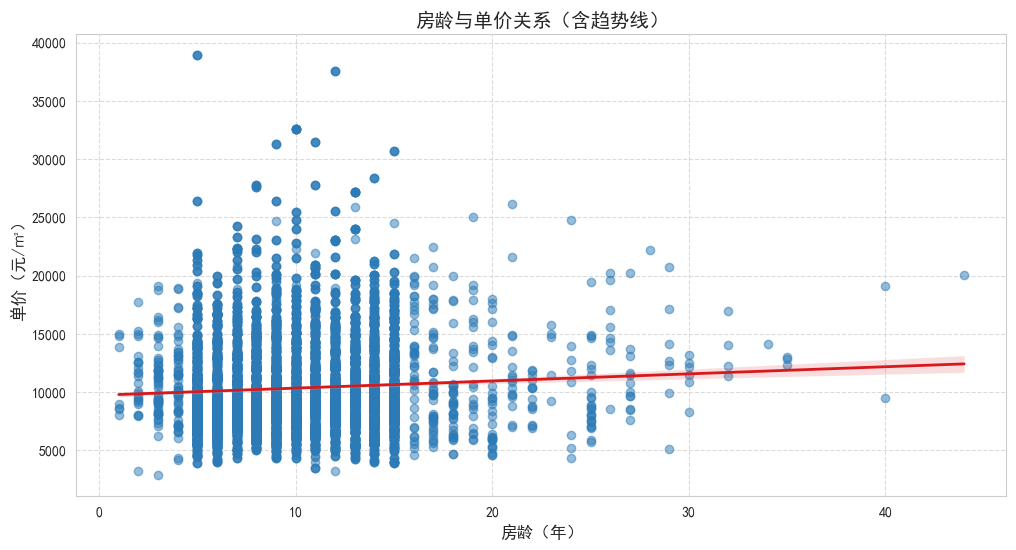

In [31]:
plt.figure(figsize=(12, 6))
sns.regplot(
    x='房龄', 
    y='单价', 
    data=df_clean, 
    scatter_kws={'alpha': 0.5, 'color': '#2c7bb6'}, 
    line_kws={'color': '#d7191c', 'linewidth': 2}
)
plt.title('房龄与单价关系（含趋势线）', fontsize=14)
plt.xlabel('房龄（年）', fontsize=12)
plt.ylabel('单价（元/㎡）', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

C:\Users\24479\AppData\Local\Temp\ipykernel_21472\3099714658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['房龄分箱'] = pd.cut(


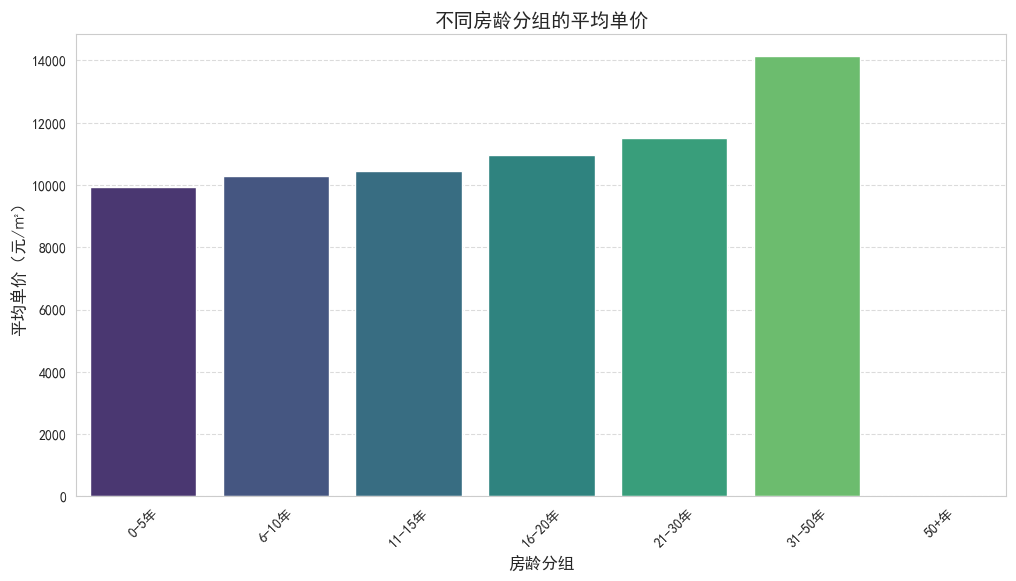

In [32]:

df_clean['房龄分箱'] = pd.cut(
    df_clean['房龄'], 
    bins=[0, 5, 10, 15, 20, 30, 50, 100], 
    labels=['0-5年', '6-10年', '11-15年', '16-20年', '21-30年', '31-50年', '50+年']
)


age_price = df_clean.groupby('房龄分箱')['单价'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    x='房龄分箱', 
    y='单价', 
    data=age_price, 
    palette='viridis', 
    order=age_price['房龄分箱']
)
plt.title('不同房龄分组的平均单价', fontsize=14)
plt.xlabel('房龄分组', fontsize=12)
plt.ylabel('平均单价（元/㎡）', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
df['单价'] = df['单价'].str.replace(r'[^\d.]', '', regex=True).astype(float)

In [8]:
df['总价（万）']=df['总价（万）'].str.replace(r'[^\d.]', '', regex=True).astype(float)

In [7]:
df.columns

Index(['标题', '总价（万）', '单价', '小区', '区域', '房间数', '大小', '朝向', '建造时间', '标签'], dtype='object')

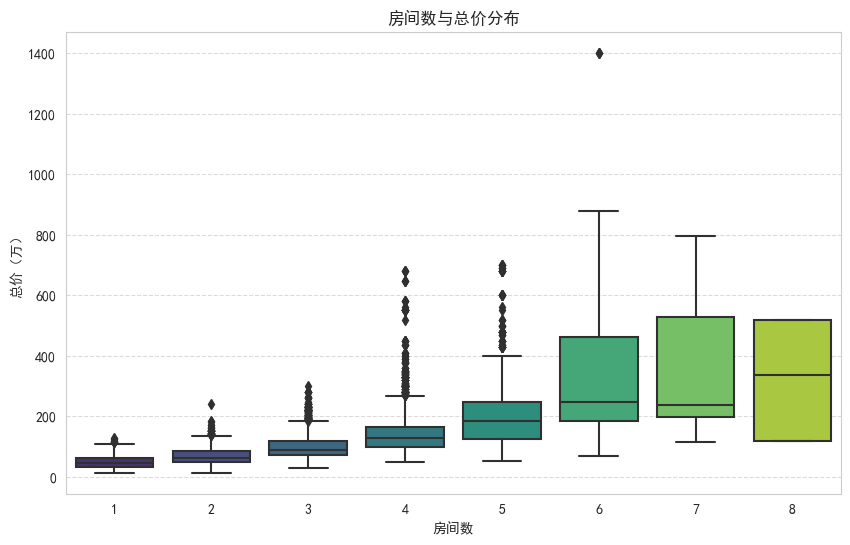

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 假设 df 是包含数据的 DataFrame
plt.figure(figsize=(10, 6))
sns.boxplot(x='房间数', y='总价（万）', data=df, palette='viridis')
plt.title('房间数与总价分布')
plt.xlabel('房间数')
plt.ylabel('总价（万）')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

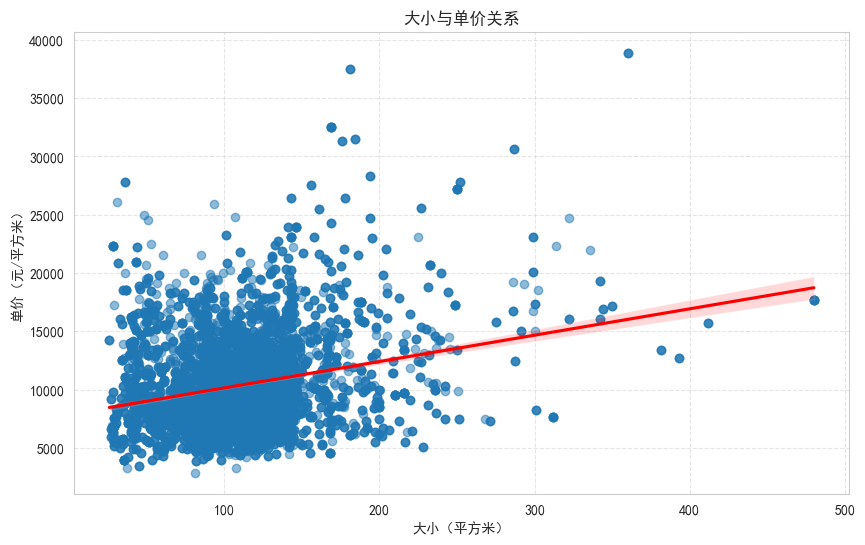

In [11]:
plt.figure(figsize=(10, 6))
sns.regplot(x='大小', y='单价', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('大小与单价关系')
plt.xlabel('大小（平方米）')
plt.ylabel('单价（元/平方米）')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

C:\Users\24479\AppData\Local\Temp\ipykernel_21472\2285114958.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='朝向', y='总价（万）', data=df, ci=None, palette='Set2')


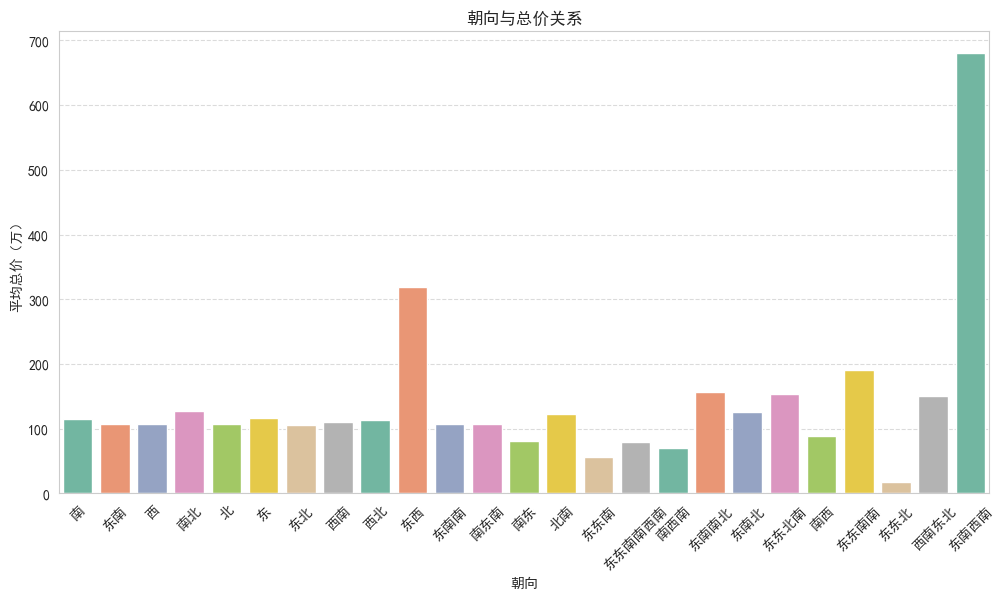

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(x='朝向', y='总价（万）', data=df, ci=None, palette='Set2')
plt.title('朝向与总价关系')
plt.xlabel('朝向')
plt.ylabel('平均总价（万）')
plt.xticks(rotation=45)  # 旋转标签避免重叠
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

,标题,总价（万）,单价,小区,区域,房间数,大小,朝向,建造时间,标签
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,[
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,'
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,'
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,","
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,'
...,...,...,...,...,...,...,...,...,...,...
9366,五象湖总部基地宜家家居旁万科品质物业,170.0,15741.0,万科金域中央一期,玉洞,4,108.00,南,2014.0,/
9366,五象湖总部基地宜家家居旁万科品质物业,170.0,15741.0,万科金域中央一期,玉洞,4,108.00,南,2014.0,随
9366,五象湖总部基地宜家家居旁万科品质物业,170.0,15741.0,万科金域中央一期,玉洞,4,108.00,南,2014.0,时
9366,五象湖总部基地宜家家居旁万科品质物业,170.0,15741.0,万科金域中央一期,玉洞,4,108.00,南,2014.0,看


In [28]:
import ast
df['标签'] = df['标签'].apply(
    lambda x: ast.literal_eval(x.replace("'", "\"")) ) # 替换单引号为双引号

AttributeError: 'list' object has no attribute 'replace'

,标题,总价（万）,单价,小区,区域,房间数,大小,朝向,建造时间,标签
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,[
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,'
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,'
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,","
0,现房！地铁口，19万，买一层得两层,19.0,6865.0,海吉星星座广场公寓,江南,2,27.68,南,NaN,'


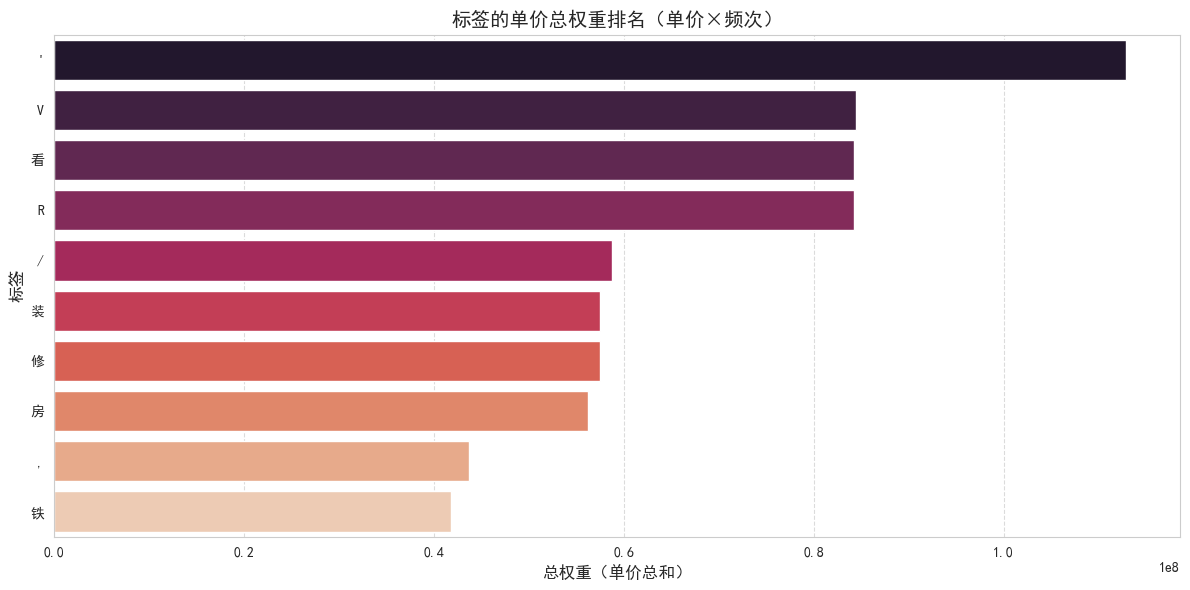

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 df 是原始数据，标签列名为 "标签"，单价列已清洗为数值类型
# 步骤1：清洗并展开标签
df['标签'] = df['标签'].apply(lambda x: [tag.strip() for tag in x if tag.strip() != ''])
df_exploded = df.explode('标签')

# 步骤2：计算每个标签的总权重（单价总和）和频次
tag_stats = df_exploded.groupby('标签').agg(
    频次=('标签', 'count'),
    总权重=('单价', 'sum')
).reset_index()

# 步骤3：筛选高频标签（例如前10名）
top_tags = tag_stats.sort_values('总权重', ascending=False).head(10)

# 步骤4：绘制横向柱状图（按总权重排序）
plt.figure(figsize=(12, 6))
sns.barplot(x='总权重', y='标签', data=top_tags, palette='rocket')
plt.title('标签的单价总权重排名（单价×频次）', fontsize=14)
plt.xlabel('总权重（单价总和）', fontsize=12)
plt.ylabel('标签', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='标签', x='单价', data=df, palette='Set2', order=df['标签'])
plt.title('高频标签与单价分布')
plt.show()

KeyboardInterrupt: 

In [33]:
import pandas as pd
df = pd.read_excel('data.xlsx', header=None)

In [34]:
total_rows = df.shape[0]
num_blocks = total_rows // 81  

In [35]:
from pandas import ExcelWriter
import re


with ExcelWriter('output.xlsx', engine='xlsxwriter') as writer:
    merged_data = pd.DataFrame()
    
    for i in range(num_blocks):
        start_idx = i * 81
        end_idx = start_idx + 81
     
        chunk = df.iloc[start_idx:end_idx]
        
        timestamp = str(chunk.iloc[0, 0])
        sheet_name = re.sub(r'[\\/*?\[\]:]', '_', timestamp)[:31]  
       
        data_part = chunk.iloc[1:].reset_index(drop=True)
       
        data_part.to_excel(writer, sheet_name=sheet_name, index=False, header=False)
        merged_data = pd.concat([merged_data, data_part], ignore_index=True)

    merged_data.to_excel('merged_data.xlsx', index=False, header=False)